In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt
import os
os.chdir('./5-3/Machine Translation/')
from nmt_utils import *

Using TensorFlow backend.


In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 13325.27it/s]


In [3]:
from pprint import pprint
pprint(dataset[:10])

[('9 may 1998', '1998-05-09'),
('10.11.19', '2019-11-10'),
('9/10/70', '1970-09-10'),
('saturday april 28 1990', '1990-04-28'),
('thursday january 26 1995', '1995-01-26'),
('monday march 7 1983', '1983-03-07'),
('sunday may 22 1988', '1988-05-22'),
('08 jul 2008', '2008-07-08'),
('8 sep 1999', '1999-09-08'),
('thursday january 1 1981', '1981-01-01')]


In [4]:
print(human_vocab)
print(machine_vocab)
print(inv_machine_vocab)

{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


In [5]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [6]:
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')
print(f'Xoh.shape = {Xoh.shape}')
print(f'Yoh.shape = {Yoh.shape}')

X.shape = (10000, 30)
Y.shape = (10000, 10)
Xoh.shape = (10000, 30, 37)
Yoh.shape = (10000, 10, 11)


In [7]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation='tanh')
densor2 = Dense(1, activation='relu')
activator = Activation(softmax, name='attention_weights')   # along axis=1
dotor = Dot(axes=1) # along axis=1(Time)

In [8]:
def one_step_attention(a, s_pre):

    '''return context'''

    s_pre = repeator(s_pre) # (m, n_s)-->(m, Tx, n_s)
    concat = concatenator([a, s_pre])   # (m, Tx, 2*n_a + n_s)
    e = densor1(concat) # (m, Tx, 10)
    eng = densor2(e)    # (m, Tx, 1)
    alphas = activator(eng) # (m, Tx, 1)
    context = dotor([alphas, a])    #(m, 2*n_a)

    return context

In [9]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state=True)    # return[a, a, c], here[s, s, c]
output_layer = Dense(len(machine_vocab), activation=softmax)

In [10]:
def model(Tx=30, Ty=10, n_a=32, n_s=64, human_vocab_size=37, machine_vocab_size=11):

    '''return nmt_model'''

    X = Input((Tx, human_vocab_size))
    s0 = Input((n_s,), name='s0')
    c0 = Input((n_s,), name='c0')
    s = s0
    c = c0
    outputs = []    # [Ty * (None, 11)]
    
    a = Bidirectional(LSTM(n_a, return_sequences=True), input_shape=(None, Tx, n_a * 2))(X)
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        out = output_layer(s)
        outputs.append(out)

    nmt_model = Model(inputs=[X, s0, c0], outputs=outputs)

    return nmt_model

In [11]:
nmt_model = model()
nmt_model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to
input_1 (InputLayer)            (None, 30, 37)       0
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]
                                                                 lstm_1[0][0]
                                                                 lstm_1[1][0]
                                                                 lstm_1[2][0]
                           

In [12]:
opt = Adam(lr=0.005, decay=0.01)
nmt_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
Y_outputs = list(Yoh.swapaxes(0, 1))
nmt_model.fit([Xoh, s0, c0], Y_outputs, epochs=1, batch_size=100)

_3_acc_3: 0.0688 - dense_3_acc_4: 0.7695 - dense_3_acc_5: 0.0725 - dense_3_acc_6: 0.0152 - dense_3_acc_7: 0.8645 - dense_3_acc_8: 0.0923 - dense_3_acc_9: 0.039 4100/10000 [===========>..................] - ETA: 1:34 - loss: 20.6420 - dense_3_loss: 2.8083 - dense_3_acc: 0.1298 - dense_3_acc_1: 0.4939 - dense_3_acc_2: 0.2227 - dense_3_acc_3: 0.0673 - dense_3_acc_4: 0.7751 - dense_3_acc_5: 0.0707 - dense_3_acc_6: 0.0149 - dense_3_acc_7: 0.8678 - dense_3_acc_8: 0.0929 - dense_3_acc_9: 0.040 4200/10000 [===========>..................] - ETA: 1:31 - loss: 20.5871 - dense_3_loss: 2.8045 - dense_3_acc: 0.1405 - dense_3_acc_1: 0.4960 - dense_3_acc_2: 0.2257 - dense_3_acc_3: 0.0657 - dense_3_acc_4: 0.7805 - dense_3_acc_5: 0.0690 - dense_3_acc_6: 0.0145 - dense_3_acc_7: 0.8676 - dense_3_acc_8: 0.0981 - dense_3_acc_9: 0.043 4300/10000 [===========>..................] - ETA: 1:29 - loss: 20.5295 - dense_3_loss: 2.8005 - dense_3_acc: 0.1514 - dense_3_acc_1: 0.4986 - dense_3_acc_2: 0.2288 - dense_3_a

In [14]:
nmt_model.load_weights('models/model.h5')

In [38]:
EGs = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001']
egs = to_categorical(np.array([string_to_int(eg, Tx, human_vocab) for eg in EGs]), len(human_vocab))  # (m, Tx) --> onehot(m, Tx, n_x)
pred = nmt_model.predict([egs, np.zeros((len(EGs), n_s)), np.zeros((len(EGs), n_s))])   # [Ty * (None, 11)]
pred = np.array(pred).swapaxes(0, 1).argmax(axis=-1)  # (Ty, None, 11)-(None, Ty, 11)-(None, Ty)
for i in range(len(EGs)):
    print(f'input [{i}]: {EGs[i]}')
    output = ''.join(int_to_string(pred[i], inv_machine_vocab))
    print(f'output[{i}]: {output}\n')

input [0]: 3 May 1979
output[0]: 1979-05-03

input [1]: 5 April 09
output[1]: 2009-05-05

input [2]: 21th of August 2016
output[2]: 2016-08-21

input [3]: Tue 10 Jul 2007
output[3]: 2007-07-10

input [4]: Saturday May 9 2018
output[4]: 2018-05-09

input [5]: March 3 2001
output[5]: 2001-03-03

input [6]: March 3rd 2001
output[6]: 2001-03-03



<Figure size 432x288 with 0 Axes>

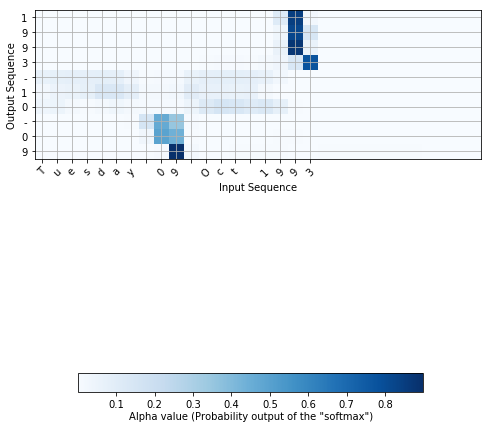

In [36]:
attention_map = plot_attention_map(nmt_model, human_vocab, inv_machine_vocab, 'Tuesday 09 Oct 1993', n_s=64, num=7, Tx=30, Ty=10)